Learn Word2Vec by implementing it in tensorflow [blog](https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac) [code](https://gist.github.com/aneesh-joshi/c8a451502958fa367d84bf038081ee4b) [jupyter_notebook](https://github.com/headwinds/python-notebooks/blob/master/nlp/tensorflow-word2vec.ipynb)
Noise Contrastive Estimation [blog](https://blog.zakjost.com/post/nce-intro/)

In [1]:
corpus = 'He is the king. The king is royal. She is the royal queen.'
print(corpus)

He is the king. The king is royal. She is the royal queen.


In [2]:
corpus_lower = corpus.lower()
print(corpus_lower)

he is the king. the king is royal. she is the royal queen.


In [3]:
corpus_without_stop_words = corpus_lower.replace('.','')
print(corpus_without_stop_words)

he is the king the king is royal she is the royal queen


In [4]:
words_list = corpus_without_stop_words.split()
print(words_list)

['he', 'is', 'the', 'king', 'the', 'king', 'is', 'royal', 'she', 'is', 'the', 'royal', 'queen']


In [5]:
words = set(words_list) # so that all duplicate words are removed
vocab_size = len(words) # gives the total number of unique words
print(words)
print(vocab_size)

{'royal', 'queen', 'he', 'is', 'the', 'king', 'she'}
7


In [6]:
word2int = {}
int2word = {}
for i, word in enumerate(words):
    word2int[word] = i
    int2word[i] = word
print(word2int)
print(int2word)

{'royal': 0, 'queen': 1, 'he': 2, 'is': 3, 'the': 4, 'king': 5, 'she': 6}
{0: 'royal', 1: 'queen', 2: 'he', 3: 'is', 4: 'the', 5: 'king', 6: 'she'}


In [7]:
raw_sentences = corpus_lower.split('.') # raw sentences is a list of sentences.
raw_sentences = raw_sentences[:-1]
print(raw_sentences)

['he is the king', ' the king is royal', ' she is the royal queen']


In [8]:
sentences = []
for sentence in raw_sentences:
    print(sentence.split())
    sentences.append(sentence.split())

['he', 'is', 'the', 'king']
['the', 'king', 'is', 'royal']
['she', 'is', 'the', 'royal', 'queen']


In [9]:
def to_one_hot(idx, vocab_size):
    return np.eye(vocab_size)[idx]

In [10]:
import numpy as np
WINDOW_SIZE = 2 
x_train = []
y_train = []
for sentence in sentences:
    for i, word in enumerate(sentence): # word <- target word
        left = max(i - WINDOW_SIZE, 0)
        right = min(i + WINDOW_SIZE, len(sentence)) + 1
        for nb_word in  sentence[left:right]: # nb_word <- context word 
            if nb_word != word:
                x_train.append(to_one_hot(word2int[nb_word], vocab_size))
                y_train.append(to_one_hot(word2int[word], vocab_size))
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
print(x_train.shape, y_train.shape)

(34, 7) (34, 7)


In [11]:
import tensorflow as tf
import numpy as np 
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [12]:
epoch = int(1e4)
lr = 1e-1

In [13]:
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y = tf.placeholder(tf.float32, shape=(None, vocab_size))

In [14]:
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')
init_b = tf.keras.initializers.zeros()

In [15]:
EMBEDDING_DIM = 5 
w1 = tf.get_variable('w1', (vocab_size, EMBEDDING_DIM), tf.float32, init_w)
b1 = tf.get_variable('b1', (EMBEDDING_DIM,), tf.float32, init_b) 
z = x@w1+b1

In [16]:
w2 = tf.get_variable('w2', (EMBEDDING_DIM, vocab_size), tf.float32, init_w)
b2 = tf.get_variable('b2', (vocab_size,), tf.float32, init_b)
logits = z@w2+b2

In [17]:
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
loss = tf.reduce_mean(entropy)
train = tf.train.GradientDescentOptimizer(lr).minimize(loss)

In [18]:
init = tf.global_variables_initializer()

In [19]:
with tf.Session() as sess:
    sess.run(init) 
    loss_trace = []
    for _ in range(epoch):
        feed_dict = {x: x_train, y: y_train}
        loss_run, _ = sess.run([loss, train], feed_dict=feed_dict)
        loss_trace.append(loss_run)
    vectors = sess.run(w1 + b1)

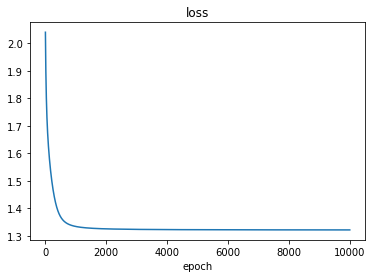

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_trace)
plt.xlabel('epoch')
plt.title('loss')
plt.show()

In [21]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
vectors = model.fit_transform(vectors) 

In [22]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

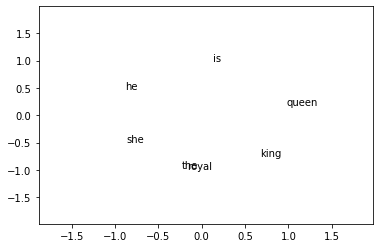

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for word in words:
    x_ = vectors[word2int[word]][0]
    y_ = vectors[word2int[word]][1] 
    ax.annotate(word, (x_, y_))
x_min = min([vectors[word2int[w]][0] for w in words])-1
x_max = max([vectors[word2int[w]][0] for w in words])+1
y_min = min([vectors[word2int[w]][1] for w in words])-1
y_max = max([vectors[word2int[w]][1] for w in words])+1
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.show()

$$\begin{array}{cccccccc}
\mbox{Word}&\mbox{One Hot Encoding}&\mbox{Word2Vec Embedding}\\
\mbox{king}&x=[0,0,0,0,0,1,0]&z=x@w_1+b_1=\mbox{vectors}[5]\\
\end{array}$$